# RNN Stocks Prediction for Royal Dutch Shell

Volatility in oil and gas company stocks has skyrocketed since the market crash in 2008, on the back of even more volatile oil and gas prices. Over the same period, concerns over the availability and negative environmental consequences of nonrenewable energy resources have compounded on the price volatility to elevate the opinions of critics of the oil and gas industry into a national discussion about the sustainability of the industry. As such, many states have passed policies that promote the use of alternative energy, including state Renewable Portfolio Standards (RPS), which require that a fraction of energy consumption must come from renewable energy sources, and the Production Tax Credit, a federal subsidy for wind farm production. The recent changes in our attitudes towards oil and gas companies raises the question of whether changes have introduced new risk to the value of these companies, such that it impacts the stock price of nonrenewable energy companies.

Paper 1: Bianconi, Marcelo and Yoshino, Joe Akira, Risk Factors and Value at Risk in Publicly Traded Companies of the Nonrenewable Energy Sector (January 13, 2013). Energy Economics, Vol. 45, 2014. Available at SSRN: https://ssrn.com/abstract=2200526 or http://dx.doi.org/10.2139/ssrn.2200526

Paper 2: Hands-On Machine Learning with Scikit-Learn and TensorFlow - by Aurélien Géron - Publisher: O'Reilly Media, Inc. - Release Date: March 2017 - ISBN: 9781491962282

Info 2: How to Estimate a Trend in a Time Series Regression Model - https://www.dummies.com/education/math/business-statistics/how-to-estimate-a-trend-in-a-time-series-regression-model/

Info 3: Time series forecasting - https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
from sklearn.preprocessing import MinMaxScaler

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 3)
mpl.rcParams['axes.grid'] = False

## 1.0. - Data selection and exploration

As stated in paper 1, the return value of an oil company is mainly driven by the oil price trend of that period and the variation in value of the euro price. We should then not only use the actual price, but the gradients of these two factors over time. 

Will will therefore import the past 5 years stock values of RDS, together with the prices of oil and the value of euro respect to usd. 

In [3]:
path = '/home/pcampolucci/ewi3615tu-ds2/src/database/'
company = 'total'
files = [company + '.csv', 'crude_oil.csv', 'euro_to_usd.csv']

# read, polish and assembly the dataframe

cols = ["Date", "Open", "High", "Low", "Close", "Adj Close" ,"Volume"]
shell = pd.read_csv(path + files[0])
shell = shell.dropna()
shell['Open'] = shell['Open'].astype(float)

oil = pd.read_csv(path + files[1])
euro = pd.read_csv(path + files[2])

shell = shell.assign(oil = oil[' value'])
shell = shell.assign(euro_usd = euro[' value'])

shell.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,oil,euro_usd
1253,2020-01-03,55.270000,55.720001,55.220001,55.470001,55.470001,1519000,61.18,1.1396
1254,2020-01-06,56.730000,56.910000,56.169998,56.509998,56.509998,3516900,63.05,1.1396
1255,2020-01-07,56.310001,56.330002,55.700001,56.189999,56.189999,2463000,63.27,1.1399
1256,2020-01-08,55.939999,56.099998,55.610001,55.849998,55.849998,2831400,62.70,1.1366
1257,2020-01-09,55.590000,56.040001,55.250000,55.880001,55.880001,2293500,59.61,1.1374


So we have the values that we need. However, we might not be interested in the plain values, but in interactions between them. First, the label that is more interesting so far would be the return of the company at a specific time t. The return is calculated as follows. 

\begin{equation*}
Return(t) = [Close(t) - Open(t)] / EuroValue(t)
\end{equation*}

The return should be normalized, as the other inputs. 

For oil and euro_usd, we can estimate the trend of the value in the last n days, and then normalize it

In [4]:
n_days = 5

shell = shell.assign(oil_change = np.gradient(shell["oil"].shift(n_days) - shell["oil"].shift(n_days + 1)))
shell = shell.assign(euro_change = np.gradient(shell["euro_usd"].shift(n_days) - shell["euro_usd"].shift(n_days + 1)))
shell = shell.assign(RETURN = (shell["Close"] - shell["Open"])/shell["euro_usd"])
shell = shell.dropna()

shell.head()

,Date,Open,High,Low,Close,Adj Close,Volume,oil,euro_usd,oil_change,euro_change,RETURN
7,2015-01-22,51.639999,52.119999,51.240002,51.950001,39.644882,2071000,46.31,1.1364,-0.977,-0.00475,0.272793
8,2015-01-23,51.180000,51.990002,51.060001,51.209999,39.080166,1321700,45.59,1.1207,-0.087,-0.00385,0.026768
9,2015-01-26,51.900002,53.139999,51.540001,52.720001,40.232510,3108400,45.15,1.1238,-0.183,0.00685,0.729666
10,2015-01-27,52.450001,53.119999,52.259998,53.099998,40.522491,1484300,46.23,1.1380,-0.593,0.00620,0.571175
11,2015-01-28,52.000000,52.000000,50.520000,50.570000,38.591759,1646400,44.45,1.1286,0.515,-0.01130,-1.267057


Getting information about the dataframe

In [5]:
shell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 7 to 1257
Data columns (total 12 columns):
Date           1251 non-null object
Open           1251 non-null float64
High           1251 non-null float64
Low            1251 non-null float64
Close          1251 non-null float64
Adj Close      1251 non-null float64
Volume         1251 non-null int64
oil            1251 non-null float64
euro_usd       1251 non-null float64
oil_change     1251 non-null float64
euro_change    1251 non-null float64
RETURN         1251 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 127.1+ KB


Before diving into model selection and training, it is useful to check visually the trends that we obtain by looking at the interested data over the years. 

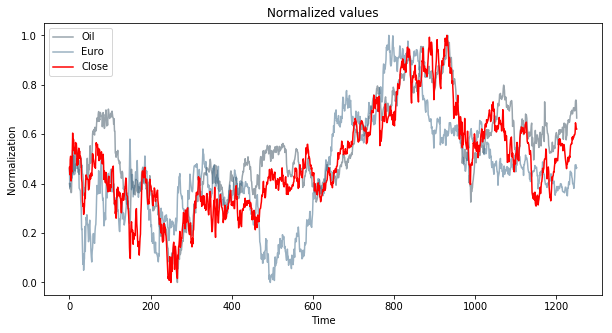

In [6]:
expl_1 = shell[['oil', 'euro_usd', 'Close']]

expl_1 = MinMaxScaler().fit_transform(expl_1)

with sns.color_palette("Blues_d"):
    
    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(data=expl_1[:,0], alpha=0.5)
    ax = sns.lineplot(data=expl_1[:,1], alpha=0.5)
    ax = sns.lineplot(data=expl_1[:,2], alpha=1, color='r')
    ax.set_title('Normalized values')
    ax.legend(loc='upper left', labels=['Oil', 'Euro', 'Close'])
    ax.set(xlabel='Time', ylabel='Normalization')

As we can see, the three factor are somewhat correlated

[Text(0,0.5,'Close Value'), Text(0.5,0,'oil change in the past n days')]

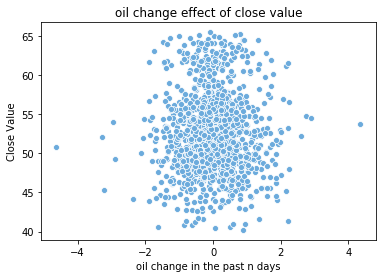

In [7]:
expl_1 = shell[['oil_change', 'euro_change', 'Close']].values

plt.figure()
ax = sns.scatterplot(expl_1[:,0], expl_1[:,2], color="#6CABDC")
ax.set_title('oil change effect of close value')
ax.set(xlabel='oil change in the past n days', ylabel='Close Value')

What we see here is interesting. It looks like that if past gradient is very negtive or very positive, it can bring very positive of negative results. 

The next step to validate out data factors is to check for correlation. With this much amount of data, a correlation matrix seems like the best choice. 

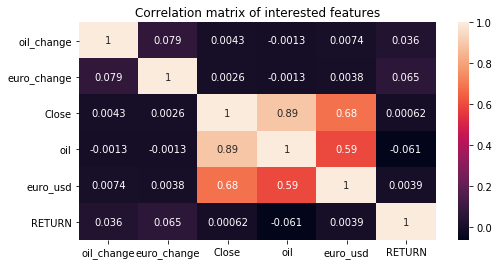

In [8]:
corr = shell[['oil_change', 'euro_change', 'Close', 'oil', 'euro_usd', 'RETURN']].corr()

plt.figure(figsize=(8, 4))
corr_plot = sns.heatmap(corr, annot=True)
corr_plot.set_title("Correlation matrix of interested features")

for item in corr_plot.get_yticklabels():
    item.set_rotation(0)

plt.show()

As expected, there is some correlation with the oil and euro prices, which would make them suitable for analysis. Nothing is detected about the relationship with the change of oil and the close value, even if they are clearly interconnected. It actually looks like that we have more usable data for the 'Close' value rather than the 'RETURN'. This has to be considered for model choice and estimation. 

# 2.0. - Prediction based on RNN

The first model to be build will consist in an RNN based multivariate predictor. Several function are pre-required to build the correct infrastructure and batches. 

We will run the first prediction on the Close value and see if we can retrieve the return. 

In [9]:
features_considered = ['oil', 'euro_usd','oil_change', 'euro_change', 'Close']

features = shell[features_considered]
features.index = shell['Date']
features.head()

,oil,euro_usd,oil_change,euro_change,Close
Date,,,,,
2015-01-22,46.31,1.1364,-0.977,-0.00475,51.950001
2015-01-23,45.59,1.1207,-0.087,-0.00385,51.209999
2015-01-26,45.15,1.1238,-0.183,0.00685,52.720001
2015-01-27,46.23,1.1380,-0.593,0.00620,53.099998
2015-01-28,44.45,1.1286,0.515,-0.01130,50.570000


The first step to build and validate is to make a proper division of indices in the dataset

In [10]:
# still have to implement the division alg from sara, for now we will use an idex

train_split = 1000 # 1000 values out of 1238 will be used for training

Lets build the feature dataset as normalized and as a numpy array

In [11]:
dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)

dataset = (dataset-data_mean)/data_std

print(f"mean normalized dataset of features = \n\n {dataset} \n")

print(f"shape of dataset = {dataset.shape}")

mean normalized dataset of features = 

 [[-0.57571183  0.05669443 -1.24287188 -1.0623431  -0.0372256 ]
 [-0.64765307 -0.25640226 -0.11019658 -0.86114387 -0.17334829]
 [-0.69161717 -0.19458062 -0.23237279  1.53089139  0.1044152 ]
 ...
 [ 1.11890421  0.12649306 -0.38763839  0.61431713  0.74271815]
 [ 1.06195072  0.06068293 -0.41945512  0.92729371  0.68017528]
 [ 0.75320287  0.0766369  -0.73762233  0.3795847   0.6856943 ]] 

shape of dataset = (1251, 5)


We now build a batch generator for the dataset and the batches

In [12]:
def make_batches(dataset, label, start, end, past_size, future_size, step, single_step=False):
    
    data = []
    labels = []
    
    start += past_size
    
    if end is None:
        # then the dataset is finished, adapt to furthest future we have
        end = len(dataset) - future_size
        
    for datum in range(start, end):
        # make an array of n training batches of m past data collection of x variables (3D array)
        idx = range(datum - past_size, datum, step)
        data.append(dataset[idx])
        
        if single_step: # then we create batches to predict only in the next observation
            labels.append(label[datum + future_size])
        
        else:
            labels.append(label[datum:datum+future_size])
            
    return np.array(data), np.array(labels)

In [13]:
# batches definition

labels = dataset[:, -1] # values to predict (in this case "Close")
n_past = 50 # time stamps that will affect the future values (the more the more computing)
n_prediction = 30 # the time stamp in the future of which we want to find the prediction
STEP = 1

train_batches, train_labels = make_batches(dataset, labels, 0, train_split, n_past, n_prediction, STEP)

valid_batches, valid_labels = make_batches(dataset, labels, train_split, None, n_past, n_prediction, STEP)

print(f"By considering 5 contributing variables and the data instered, we obtain: ")
print(f"\nTrain data of shape: {train_batches.shape} and {train_labels.shape}")
print(f"\nValidation data of shape: {valid_batches.shape} and {valid_labels.shape}\n")
print ('Single window of past history : {}'.format(train_batches[0].shape))
print ('Single window of predicted output : {}'.format(train_labels[0].shape))

By considering 5 contributing variables and the data instered, we obtain: 

Train data of shape: (950, 50, 5) and (950, 30)

Validation data of shape: (171, 50, 5) and (171, 30)

Single window of past history : (50, 5)
Single window of predicted output : (30,)


Let's now use tf.data to shuffle, batch, and cache the dataset.

Info buffer size: The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. The buffer_size in Dataset.prefetch() only affects the time it takes to produce the next element.

Info batch size: the batch size make batches out of the data shape specified. 

In [14]:
BATCH_SIZE = 100 # single example batch size
BUFFER_SIZE = 1000 # level of randomness

train = tf.data.Dataset.from_tensor_slices((train_batches, train_labels))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validate = tf.data.Dataset.from_tensor_slices((valid_batches, valid_labels))
validate = validate.batch(BATCH_SIZE).repeat()

## 2.1. - Build Prediction Model

Once the data is ready to be fed, the model needs to be build and fed with these ones. The current model is built as following around a specialized RNN layer called Long Short Term Memory (LSTM). The model is built as following:

- **models**: Code for model cloning, plus model-related API entries. It can be of class `Model` (groups layers into an object with training and inference features) or `Sequential` (Linear stack of layers)

- **layers**: Type of model layers: its full of choices for for now we will use LSTM and Dense, but it can be changed). 

- **optimizer**: it defines the error required to be minimized, in this case MAE

In [15]:
# LSTM requires the input shape of the data it is being given.

lstm_model = tf.keras.models.Sequential()

lstm_model.add(tf.keras.layers.LSTM(32,
                                    return_sequences=True, 
                                    input_shape=train_batches.shape[-2:])) # 32 units
               
lstm_model.add(tf.keras.layers.LSTM(16,
                                    activation='relu')) # 32 unitstrain_batches.shape[-2:])) # 32 units
               
lstm_model.add(tf.keras.layers.Dense(30)) # 1 unit

lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

## 2.2. - Train the Model

The next step is to feed training data to the model defined to obtain a predictive algorithm. The information to define is the following (see fit https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

- `EPOCHS`: Iterations on the dataset
- `EVAUATION INTERVAL`: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size.
- `validation_steps`:  Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.


In [16]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

trained_alg = lstm_model.fit(train, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=validate,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 36ms/step - loss: 0.3519 - val_loss: 0.5517
Epoch 2/10
200/200 [==============================] - 6s 29ms/step - loss: 0.2280 - val_loss: 0.6096
Epoch 3/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1958 - val_loss: 0.6607
Epoch 4/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1781 - val_loss: 0.6486
Epoch 5/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1684 - val_loss: 0.5721
Epoch 6/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1602 - val_loss: 0.5939
Epoch 7/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1538 - val_loss: 0.5596
Epoch 8/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1479 - val_loss: 0.5849
Epoch 9/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1426 - val_loss: 0.6225
Epoch 10/10
200/200 [===========================

## 2.3. - Validate the Model

Time to validate. First step is to check for every epoch what is the loss and the validation loss. This can help us in understanding if the current training model is not diverging in errors; if so, then we have to change parameters. 

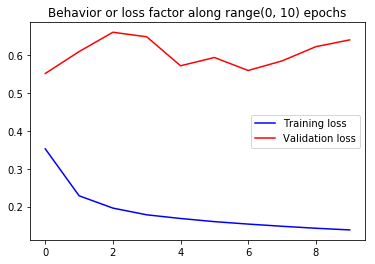

In [17]:
# define a function to plot the loss factors

def plot_train_history(history):
    
    # from the trained algorithm is possible to retieve the loss data during training and validation
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # the x axis corresponds to the epochs that we performed
    epochs = range(len(loss))
    
    # plot the values
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f"Behavior or loss factor along {epochs} epochs")
    plt.legend()

    plt.show()
    
plot_train_history(trained_alg)

Now that the model is trained, let's make a few sample predictions. 

In [52]:
unknown = dataset[-50:, :]
unknown = unknown[np.newaxis, ...]

(50,) (50,) (30,) (30,)


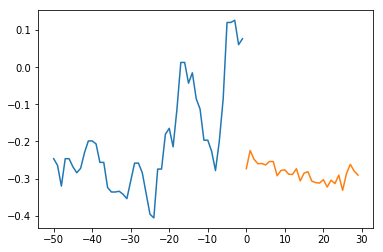

In [59]:
def get_time(length):
    
    time = []
    for step in range(-length, 0, 1):
        time.append(step)
    
    return time

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = get_time(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def multi_step_plot(history, true_future, prediction, sample_n):
    plt.figure(figsize=(8, 4))
    plt.title(f"30 days prediction for sample {sample_n+1}")
    num_in = get_time(len(history))
    num_out = 30 # len(true_future)

    plt.plot(num_in, np.array(history[:, -1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Close (Normalized)')
    plt.show()
    
def get_data_for_plot(history, prediction):

    time_history = np.array(get_time(len(history)))
    close_history = np.array(history[:, 1])
    time_future = np.arange(prediction.shape[0])
    close_future = np.array(prediction)

    return time_history, close_history, time_future, close_future

samples = 4
y_known = np.zeros((n_prediction, samples))
y_predict = np.zeros((n_prediction, samples))
count = 0

"""for x, y in validate.take(samples):
    print(x[-1].shape, lstm_model.predict(x)[0].shape[0])
    y_known[:, count] = y[0]
    y_predict[:, count] = lstm_model.predict(x)[0]
    multi_step_plot(x[-1], y[-1], lstm_model.predict(x)[-1], count)
    count += 1"""

a, b, c, d = get_data_for_plot(unknown[0], lstm_model.predict(unknown)[0])

print(a.shape, b.shape, c.shape, d.shape)
plt.figure()
plt.plot(a, b)
plt.plot(c, d)
plt.show()

In the stock market what is useful to predict is the trend, since is interesting to understand if the a stock is planned to recover or not, or maybe a pattern might presume a sudden fall. Therefore is useful to estimate the error of the prediction in the single days but more importantly the error in the predicted trend. 

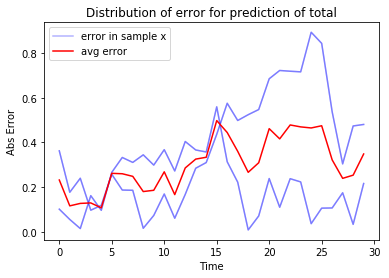

In [36]:
x_axis = np.arange(0, n_prediction)
avg_error = np.mean(np.abs(y_known - y_predict), axis=1)

plt.figure()
plt.title(f"Distribution of error for prediction of {company}")
for i in range(samples):
    plt.plot(x_axis, np.abs(y_known[:, i] - y_predict[:, i]), alpha=0.3, color="b", label="error in sample x")
    
plt.plot(x_axis, avg_error, color="r", label="avg error")
plt.legend(loc='upper left')
plt.xlabel("Time")
plt.ylabel("Abs Error")
plt.show()

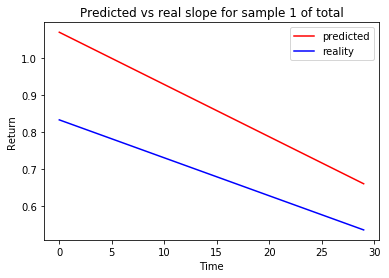

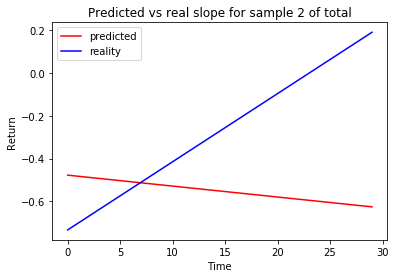

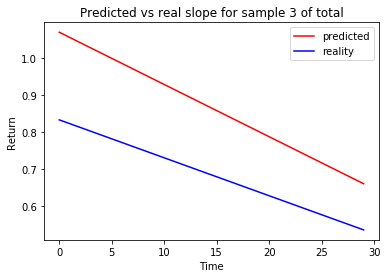

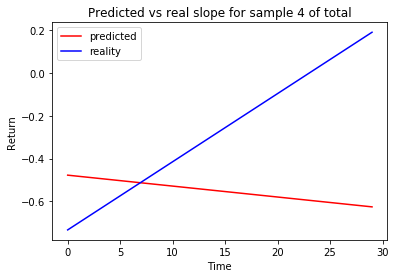

In [37]:
from sklearn import datasets, linear_model

for i in range(samples):

    # Create linear regression object
    regr_pred = linear_model.LinearRegression()
    regr_real = linear_model.LinearRegression()

    # Train the model using the training sets
    regr_pred.fit(x_axis.reshape(-1, 1), y_predict[:, i].reshape(-1, 1))
    regr_real.fit(x_axis.reshape(-1, 1), y_known[:, i].reshape(-1, 1))

    b0_pred = regr_pred.intercept_
    b0_real = regr_real.intercept_
    b1_pred = regr_pred.coef_
    b1_real = regr_real.coef_

    b0_error = abs(b0_pred - b0_real)
    b1_error = abs(b1_pred - b1_real)

    plt.figure(i)
    plt.title(f"Predicted vs real slope for sample {i+1} of {company}")
    plt.plot(x_axis, (b0_pred + b1_pred*x_axis).T, label="predicted", color="r")
    plt.plot(x_axis, (b0_real + b1_real*x_axis).T, label="reality", color="b")
    if b1_real > 0:
        plt.legend(loc='upper left')
    else:
        plt.legend(loc='upper right')
    plt.xlabel("Time")
    plt.ylabel("Return")
    
plt.show()

In [ ]:
wd loss: 0.1674 - val_loss: 4.2236
shell loss: 0.1191 - val_loss: 0.4431
eni loss: 0.1554 - val_loss: 0.6591